In [1]:
### original dataset
import tensorflow as tf
config = tf.compat.v1.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

Metal device set to: Apple M1


2022-03-23 14:46:37.264259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-23 14:46:37.264362: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import os
from os import listdir
from os.path import isfile, join

import math
import random


from datetime import datetime

import cv2
import numpy as np

import matplotlib.pyplot as plt

import imgaug as ia
import imgaug.augmenters as iaa

from sklearn.utils import class_weight

from tensorflow.keras.utils import Sequence

# 데이터 준비

In [3]:
def get_filelist(file_dir):
    """
    Get a list of files in a path.
    Args:
        file_dir: dataset path
    Returns:
        file_list: list of files the dataset path
        class_list: list of classname the dataset path
    """
    included_extensions = ['jpg','jpeg', 'bmp', 'png', 'gif']

    class_list = []
    file_list = []
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(file_dir)):
        if i==0:
            class_list = dirnames
        file_list += [os.path.join(dirpath, fn) for fn in filenames
                       if any(fn.lower().endswith(ext) for ext in included_extensions)]
        
    class_list.sort()
    return file_list, class_list

def get_word2int(class_list):
    """
    A dictionary that converts text classes to numbers.
    Args:
        class_list: [char1, char2, char3,...,charN], (example) ["a0","b1","c1","bc1"]
    Returns:
        char_to_int: {char: int, ...}
        int_to_char: {int: char, ...}
    """
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(class_list))
    int_to_char = dict((i, c) for i, c in enumerate(class_list))
    return char_to_int, int_to_char

def one_hot(a, num_classes):
    """
    One-hot encoding conversion of integers.
    Args:
        a: class number converted to integer
        num_classes: Total number of classes
    Returns:
        One-hot encoding results
    """
    return np.eye(num_classes)[a]

def create_dir(dir_name):
    """Creating directory
    Args:
        dir_name: directory name
    """
    if os.path.isdir(dir_name)==False:
        os.makedirs(dir_name)
        print("create directory: ", dir_name)

In [4]:
# set image augumentation
ia.seed(1)

sometimes02 = lambda aug: iaa.Sometimes(0.2, aug)
sometimes05 = lambda aug: iaa.Sometimes(0.5, aug)
sometimes08 = lambda aug: iaa.Sometimes(0.8, aug)

seq_img_filter = iaa.Sequential([
        iaa.Fliplr(0.5),
        sometimes08(iaa.Affine(
            scale={"x": (0.9, 1.0), "y": (0.9, 1.05)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
            rotate=(-15, 15), # rotate by -45 to +45 degrees
            #shear=(-5, 5), # shear by -16 to +16 degrees
        ),
                   ),
])

noise_fillter = iaa.Sequential([
                sometimes05(iaa.OneOf([
                    iaa.GaussianBlur((0, 0.3)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 5)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                ])),
                sometimes05([
                    #iaa.SaltAndPepper(0.01, 0.05),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                    iaa.GammaContrast((0.5, 2.0), per_channel=True)
                ]),

])


In [5]:
def get_class_data_num(file_list, class_list, class_char2int):
    """
    Set the number of dataset files by class
    Args:
         file_list: List of dataset file paths
         class_list: List of dataset classes
         class_char2int: a dictionary taking the string class as an int
     Returns:
         class_dict: A dictionary of the number of dataset files by class
    """
    
    class_dict = {}
    for class_name in class_list:
        class_dict[class_char2int[class_name]]=0
        
    for fn in file_list:
        class_name = fn.split("/")[-2]
        class_dict[class_char2int[class_name]]+=1
    return class_dict

def create_class_weight(labels_dict, mu=0.15):
    """
    tensorflow class weighting function
    """
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

In [6]:
class CustomDataloader(Sequence):
    def __init__(self, 
                 file_dir, 
                 batch_size, 
                 img_size,
                 out_size=12,
                 aug_op=False,
                 shuffle=True,
                 multi_op=False,
                 sample_n=1024,
                 ann_dir = "./data/ann_4"
                 
                ):
        """
        Custum tensorflow dataloader
        Args:
            file_dir: Dataset directory path
            batch_size: batch size
            img_size: input image size
            out_size: size of the output image
            aug_op: use data augmentation boolean
            shuffle: data shuffle data augmentation after 1 epoch
            multi_op: ouput type -> True: [class label, eye nose mouth heat map], False: class label
            sample_n: number of samples to use as data
        
        """
        
        self.ann_dir = ann_dir
        
        self.file_list, self.class_list = get_filelist(file_dir)
        random.seed(1)
        random.shuffle(self.file_list)
        
        self.class_char2int, self.class_int2char = get_word2int(self.class_list)
        
        self.batch_size = batch_size
        self.img_size = img_size
        self.out_size = out_size
        
        self.aug_op = aug_op
        self.shuffle = shuffle
        self.multi_op = multi_op
        self.sample_n = sample_n
        
        self.file_list = self.file_list[:self.sample_n] if self.sample_n>0 else self.file_list
        
        self.file_n = len(self.file_list)
        self.class_n = len(self.class_list)
        self.class_data_num = get_class_data_num(self.file_list, self.class_list, self.class_char2int)
        self.on_epoch_end()
 
    def __len__(self):
        return math.ceil(self.file_n / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = []
        batch_y1 = []
        batch_y2 = []
        self.batch_fn = []
        for i in indices:
            try:
                img = cv2.imread(self.file_list[i], cv2.IMREAD_COLOR)
                
                if len(img)==0:
                    continue
                    
                fine_name = self.file_list[i].split("/")[-1]
                if self.multi_op:
                    heatmap_path = join(self.ann_dir, "ann_"+fine_name)
                    if isfile(heatmap_path):
                        heatmap_img = cv2.imread(heatmap_path, cv2.IMREAD_GRAYSCALE)

                    else:
                        heatmap_img = np.zeros([self.out_size,self.out_size],dtype=np.uint8)

                if self.aug_op:
                    #seq_img_filter = seq_img_filter.localize_random_state()
                    
                    # 회전, 크롭 등
                    #seq_img_f = seq_img_filter.to_deterministic()
                    #seq_img_f = seq_img_filter.to_deterministic()
                    
                    img = seq_img_filter.augment_image(img)
                    if self.multi_op:
                        heatmap_img = seq_img_f.augment_image(heatmap_img)
                    
                    # 블러, 노이즈 등
                    #img = noise_fillter.augment_image(img)

                w,h = img.shape[:2]
                if w!=self.img_size or h!=self.img_size:
                    img = cv2.resize(img, (self.img_size,self.img_size))

                # input x
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255. #-0.5
                batch_x.append(img)
                self.batch_fn.append([self.file_list[i], i])
                
                # label class name
                class_name = self.file_list[i].split("/")[-2]
                class_idx = self.class_char2int[class_name]
                class_one_hot = one_hot(class_idx,self.class_n)
                batch_y1.append(class_one_hot)
                
                if self.multi_op:
                    # label heatmap 
                    heatmap_img = cv2.resize(heatmap_img,(self.out_size,self.out_size))
                    heatmap_img = heatmap_img.reshape(self.out_size*self.out_size)
                    heatmap_img = heatmap_img/255.
                    batch_y2.append(heatmap_img)
                
            except Exception as e:
                print("e",e)
            
        batch_x = np.array(batch_x)
        batch_y1 = np.array(batch_y1)
        batch_y2 = np.array(batch_y2)
        
        if self.multi_op:
            return batch_x, [batch_y1, batch_y2]
        else:
            return batch_x, batch_y1
    
    def on_epoch_end(self):
        self.indices = np.arange(self.file_n)
        if self.shuffle == True:
            np.random.shuffle(self.indices)
        

---
## 데이터로더 생성

In [7]:
img_size = 112
# out_size= 12
batch_size = 32
multi_output = False

dataset_dir = "./data/face_datasets_5"
train_file_dir = join(dataset_dir,"train")
val_file_dir = join(dataset_dir,"val")
test_file_dir = join(dataset_dir,"test")

train_loader = CustomDataloader(train_file_dir, batch_size, img_size, aug_op=True, sample_n=-1, multi_op=multi_output)
val_loader = CustomDataloader(val_file_dir, batch_size, img_size, aug_op=False, sample_n=-1, multi_op=multi_output)
test_loader = CustomDataloader(test_file_dir, batch_size, img_size, aug_op=False, sample_n=-1, multi_op=multi_output,shuffle=False)


In [8]:
class_int2char = train_loader.class_int2char
print("class_int2char: ",class_int2char)

train_data_num = train_loader.file_n
print("train_data_num: ",train_data_num)

class_data_num = train_loader.class_data_num
print("class_data_num: ", class_data_num)

class_int2char:  {0: 'a0', 1: 'b1', 2: 'bc1', 3: 'bg', 4: 'c1'}
train_data_num:  15010
class_data_num:  {0: 4769, 1: 1451, 2: 2370, 3: 1435, 4: 4985}


In [ ]:
# show dataset

n_batch = next(iter(train_loader))
x, y = n_batch

r_idx = random.randint(0,len(x)-1)

file_name = train_loader.batch_fn[r_idx]
print("file_name: ", file_name)

plt.imshow(x[r_idx])
plt.show()

if multi_output:
    label_class = y[0][r_idx]
    label_img = y[1][r_idx].reshape(out_size,out_size)
    plt.imshow(label_img)
    plt.show()
else:
    label_class = y[r_idx]
    
print("class: ", class_int2char[np.argmax(label_class)])
train_loader.on_epoch_end()

---
## 모델 만들기

In [10]:
import tensorflow as tf

In [11]:
# Learning Results Viewing Tool
def vis(history, name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_list = list(history.history.keys())
    key_list.sort()
    key_value = list(set([i.split("val_")[-1] for i in key_list]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

In [12]:
def mobilenet_occluded_model(input_shape=(112,112,3), num_class = 5, drop=0.2):
    """
    Non-occluded classification model based on MobileNetV2.
     Args:
         input_shape: the input shape of the model
         num_class: number of outputs
     Returns:
         model: Non-occluded classification model
    """
    act_f = "swish"
    kernel_reg = tf.keras.regularizers.l2(0.001)
    kernel_init = tf.keras.initializers.he_normal(seed=1)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
    
    inputs = tf.keras.Input(shape=input_shape)
    x_base = base_model(inputs, training=True)
    x_avg1 = tf.keras.layers.GlobalAveragePooling2D()(x_base)
    
    x1 = tf.keras.layers.Dropout(drop)(x_avg1)
    x1 = tf.keras.layers.Dense(1024, activation=act_f, kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x1)
    x1 = tf.keras.layers.Dropout(drop)(x1)
    x1 = tf.keras.layers.Dense(512, activation=act_f, kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x1)
    
    outputs1 = tf.keras.layers.Dense(num_class, activation='softmax',name='output_1')(x1)
    
    model = tf.keras.Model(inputs,outputs1)
    
    return model

NUM_CLASS = train_loader.class_n
IMG_SHAPE = (img_size, img_size, 3)

print("NUM_CLASS: ", NUM_CLASS)
print("IMG_SHAPE: ", IMG_SHAPE)

model = mobilenet_occluded_model(IMG_SHAPE, NUM_CLASS)

NUM_CLASS:  5
IMG_SHAPE:  (112, 112, 3)


2022-03-23 14:46:53.297680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-23 14:46:53.297708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Flatten, Activation,  concatenate, Reshape
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [14]:
# def simplecnn_occluded_model(input_shape=(112,112,3),  num_class=5, drop=0.2):
#     """
#     Non-occluded classification model based on MobileNetV2.
#      Args:
#          input_shape: the input shape of the model
#          num_class: number of outputs
#      Returns:
#          model: Non-occluded classification model
#     """
    
#     act_func = "swish"
#     kernel_reg = tf.keras.regularizers.l2(0.001)
#     kernel_init = tf.keras.initializers.he_normal(seed=1) 
    
#     # Stage 1 #
#     img_input = Input(shape=input_shape)
    
#     ## Block 1 ##
#     x = Conv2D(32, (3,3), strides=(1,1), name='base_conv1', kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(img_input)
#     x = BatchNormalization()(x)
#     x = Activation(act_func, name='base_conv1_act')(x)
#     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='base_conv1_pool')(x)

#     ## Block 2 ##
#     x = Conv2D(64, (3,3), strides=(1,1), name='base_conv2', kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = BatchNormalization()(x)
#     x = Activation(act_func, name='base_conv2_act')(x)
#     x = Conv2D(64, (3,3), strides=(1,1), name='base_conv3', kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = BatchNormalization()(x)
#     x = Activation(act_func, name='base_conv3_act')(x)
#     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='base_conv3_poo1')(x)

#     ## Block 3 ##
#     x = Conv2D(64, (3,3), strides=(1,1), name='base_conv4', kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = BatchNormalization()(x)
#     x = Activation(act_func, name='base_conv4_act')(x)
#     x = Conv2D(64, (3,3), strides=(1,1), name='base_conv5', kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = BatchNormalization()(x)
#     x = Activation(act_func, name='base_conv5_act')(x)
#     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), name='base_conv5_poo1')(x)
        
#     ## Block 4 ##
#     x = Conv2D(256, (3,3), strides=(1,1), name='base_conv6', kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = BatchNormalization()(x)
#     x = Activation(act_func, name='base_conv6_act')(x)
#     x = Dropout(0.5)(x)
    
#     ## Block 5 ##
#     x = Flatten(name='base_flatten')(x)
#     x = Dense(1024, activation=act_func, kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = Dropout(0.2)(x)
    
#     x = Dense(512, activation=act_func, kernel_regularizer=kernel_reg, kernel_initializer=kernel_init)(x)
#     x = Dropout(0.2)(x)
   
#     # Activation function을 적용하면 output의 범위를 [0,1]로 제한하게 되므로 
#     #x = Dense(output_size, activation="sigmoid", name="out1")(x)
#     x = Dense(num_class, activation="softmax", name="out1")(x)
#     model = Model(img_input, x)
    
#     return model


# IMG_SHAPE = (img_size, img_size, 3)
# NUM_CLASS = train_loader.class_n

# model = simplecnn_occluded_model(input_shape=IMG_SHAPE,  num_class=NUM_CLASS)

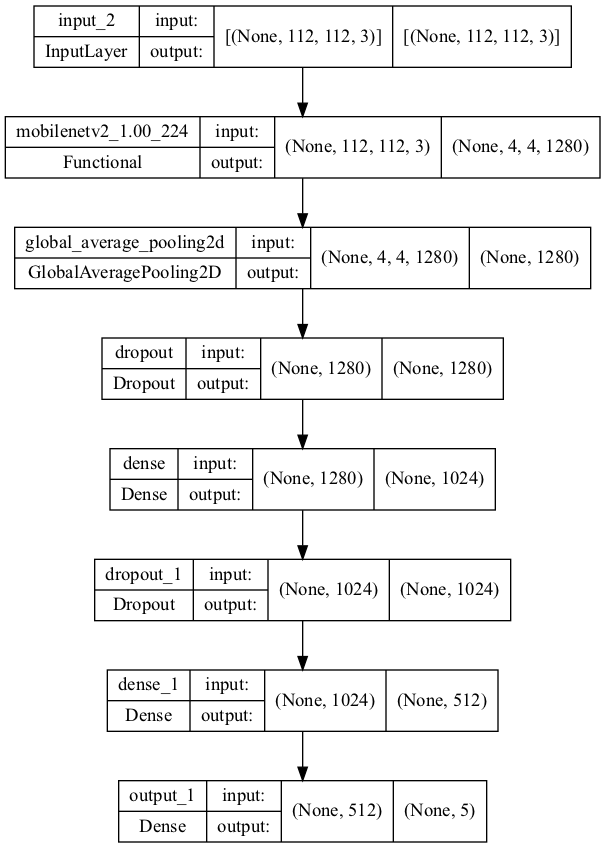

In [15]:
import keras
keras.utils.vis_utils.plot_model(model, to_file='./model_structure/mobilenet_occluded_model.png', show_shapes=True, show_layer_names=True)

In [14]:
# model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

## 모델 학습 준비

In [20]:
# model compile

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
#opt = tf.keras.optimizers.SGD( lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5 )
#opt = tf.keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

# target이 one-hot encoding인 경우: categorical_crossentropy
# target이 int형 레이블인 경우: sparse_categorical_crossentropy
model.compile(optimizer=opt, 
              loss=["categorical_crossentropy"], 
              metrics=["accuracy"])

In [16]:
# load pre-trained weight
if False:  
    load_w_path = "./pre_w/5class_mobilenet_classification_bset_0320_1915.h5".format(root_dir)
    model = tf.keras.models.load_model(load_w_path)
    print("loaded: ", load_w_path)

In [22]:
# set checkpoint

now = datetime.today().strftime('%m%d_%H%M')
ckp_filepath = 'pre_w/simple_5class_best_{}.h5'.format(now)
print("ckp_filepath: ",ckp_filepath)

# ckp_filepath = 'pre_w/5class_sigmoid_0320_940.h5'
my_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=ckp_filepath, 
                             monitor="val_loss",
                             verbose=2, 
                             save_best_only=True,
                             mode="min")

ckp_filepath:  pre_w/simple_5class_best_0321_2354.h5


## 학습

In [19]:
epochs = 10
history = model.fit(train_loader, 
                   validation_data=val_loader, 
                   epochs=epochs,
                   batch_size=batch_size,
                   verbose=0,
                   workers=4,# multi로 처리할 개수
                   #callbacks=[callback,my_checkpoint],
                   #callbacks=[my_checkpoint],
                   #class_weight=create_class_weight(class_data_num)
                  )

In [ ]:
plot_history(history)


---

## save model


In [17]:
## load best model
load_ckp_filepath = "./pre_w/mobilenetv2_52_5class_swift_best.loss0.40.h5" #ckp_filepath 
load_model=tf.keras.models.load_model(load_ckp_filepath)

## save model sturucture and trained weight
now = datetime.today().strftime('%m%d_%H%M')

save_traininfo_dir = "./train_info"
save_traininfo_dir = join(save_traininfo_dir, now)
create_dir(save_traininfo_dir)

save_model_path = join(save_traininfo_dir, "best_model.h5")  # ckp_filepath.replace("pre_w",save_traininfo_dir)
print("save_model_path: ", save_model_path)

load_model.save(save_model_path)

## save label dictionary
import pickle

save_class_int2char_path = join(save_traininfo_dir,"class_int2char.pkl")
print("save_class_int2char_path: ",save_class_int2char_path)

with open(save_class_int2char_path, 'wb') as handle:
    pickle.dump(class_int2char, handle)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print(a == b)

create directory:  ./train_info/0323_1448
save_model_path:  ./train_info/0323_1448/best_model.h5
save_class_int2char_path:  ./train_info/0323_1448/class_int2char.pkl


---
## Predict

### predict from dataset

In [18]:
load_ckp_filepath = "./train_info/0323_1448/best_model.h5"#load_ckp_filepath
load_model=tf.keras.models.load_model(load_ckp_filepath)

evaluate_result = load_model.evaluate(train_loader)
evaluate_result = load_model.evaluate(val_loader)



2022-03-23 14:48:40.808878: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-23 14:48:41.177259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


108/108 [==============================] - 5s 49ms/step - loss: 0.4801 - accuracy: 0.9067


In [ ]:
# show dataset

n_batch = next(iter(test_loader))
x, y = n_batch

p_label = load_model.predict(x)
r_idx = random.randint(0,len(x)-1)

file_name = test_loader.batch_fn[r_idx]
print("file_name: ", file_name)

plt.imshow(x[r_idx])
plt.show()

if multi_output:
    label_class = p_label[0][r_idx]
    label_img = p_label[1][r_idx].reshape(out_size,out_size)
    plt.imshow(label_img)
    plt.show()
else:
    label_class = p_label[r_idx]
    
print("class: ", class_int2char[np.argmax(label_class)])
train_loader.on_epoch_end()




---
### predict from local image

In [20]:
def img_2_inputx(img, input_shape):
    """
    convert opencv image to input x
    Args:
        img: opencv image
    Returns:
        input_x: model input x
    """
    img = cv2.resize(img,input_shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #-0.5
    input_x = np.expand_dims(img,axis=0)/255.
    return input_x

In [ ]:
sample_img_path = './data/face_datasets_5/test/a0/sample.jpg'
sample_img = cv2.imread(sample_img_path)
sample_x = img_2_inputx(sample_img, (img_size,img_size))

p_arr = load_model.predict(sample_x)

plt.imshow(sample_img)
plt.show()

if multi_output:
    label_class = p_label[0][0]
    label_img = p_label[1][0].reshape(out_size,out_size)
    plt.imshow(label_img)
    plt.show()
else:
    label_class = p_label[0]

print("class: ", class_int2char[np.argmax(label_class)], np.max(label_class))

### Incorrect data view

In [ ]:
# predict test dataset
# Check incorrect data
predicted_result = load_model.predict(test_loader)
predicted_labels = np.argmax(predicted_result, axis=1)

class_char2int = test_loader.class_char2int
test_labels = [class_char2int[x.split("/")[-2]] for x in (test_loader.file_list)]

wrong_result = []

for n in range(0, len(test_labels)):
    if predicted_labels[n] != test_labels[n]:
        wrong_result.append(n)
print("wrong_result rate: {}, amount: {}".format(len(wrong_result)/(test_loader.file_n), len(wrong_result)))

random.shuffle(wrong_result)
samples = wrong_result[:min(16,len(wrong_result))]#random.choices(population=wrong_result, k=min(16,len(wrong_result)))

count = 0
nrows = ncols = 4

print("y: label, p: predict, c:confidence")
plt.figure(figsize=(12,8))
for n in samples:
    count += 1
    plt.subplot(nrows, ncols, count)
    x_data = cv2.imread(test_loader.file_list[n])
    x_data = cv2.cvtColor(x_data, cv2.COLOR_BGR2RGB)
    plt.imshow(x_data, cmap='Greys', interpolation='nearest')
    
    conf = round(predicted_result[n][predicted_labels[n]],2)
    
    t_label = class_int2char[test_labels[n]]
    p_label = class_int2char[predicted_labels[n]]
    tmp = "y:" + str(t_label) + ", p:" + str(p_label) +", c:" +str(conf)
    plt.title(tmp)

plt.tight_layout()
plt.show()

---
# convert tfilte

In [60]:
from os.path import join

import pickle
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [61]:
import tensorflow as tf

In [62]:
def img_2_inputx(img, input_shape):
    """
    convert opencv image to input x
    Args:
        img: opencv image
    Returns:
        input_x: model input x
    """
    img = cv2.resize(img,input_shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #-0.5
    input_x = np.expand_dims(img,axis=0)/255.
    return input_x

In [63]:
# load_ckp_filepath = "/Users/hy_mac/Project/kakaopay/occluded_face_project/pre_w/mobilenet_5class_best_0320_2224.h5"#ckp_filepath 
load_model = tf.keras.models.load_model(load_ckp_filepath)

load_model.trainable=False
converter = tf.lite.TFLiteConverter.from_keras_model(load_model)
tflite_model = converter.convert()



INFO:tensorflow:Assets written to: /var/folders/72/0l8b72dx32scxt2bd_r2kf900000gn/T/tmpkbf91ncs/assets


INFO:tensorflow:Assets written to: /var/folders/72/0l8b72dx32scxt2bd_r2kf900000gn/T/tmpkbf91ncs/assets
2022-03-23 00:07:54.844178: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-23 00:07:54.844192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-23 00:07:54.844276: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/72/0l8b72dx32scxt2bd_r2kf900000gn/T/tmpkbf91ncs
2022-03-23 00:07:54.862972: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-23 00:07:54.862989: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/72/0l8b72dx32scxt2bd_r2kf900000gn/T/tmpkbf91ncs
2022-03-23 00:07:54.931251: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-23 00:07:55.387475: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [64]:
# Save tflite.
save_traininfo_dir ="./train_info/0322_2340/"
tflite_model_path = join(save_traininfo_dir, "best_model.tflite")
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)
    
load_traininfo_dir = save_traininfo_dir
load_class_int2char_path = join(load_traininfo_dir,"class_int2char.pkl")
# class_int2char = {0: 'a0', 1: 'b1', 2: 'bc1', 3: 'bg', 4: 'c1'}
with open(load_class_int2char_path, 'rb') as handle:
    class_int2char = pickle.load(handle)
print("class_int2char: ", class_int2char)

model_content = True
if model_content:
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
else:
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    
interpreter.allocate_tensors()

input1 = interpreter.get_input_details()[0]  # Model has single input.
output = interpreter.get_output_details()[0]  # Model has single output.


class_int2char:  {0: 'a0', 1: 'b1', 2: 'bc1', 3: 'bg', 4: 'c1'}


In [ ]:
img_size = 112
sample_img = cv2.imread('./face_datasets_4/test/b1/sample.jpg')
input_data = img_2_inputx(sample_img, (img_size,img_size))
input_data = np.array(input_data, dtype=np.float32)
interpreter.set_tensor(input1['index'], input_data)
interpreter.invoke()

plt.imshow(sample_img)
plt.show()

# out_predict = interpreter.get_tensor(output[1]['index'])
out_predict = interpreter.get_tensor(output['index'])
label_class = out_predict[0]
print("class: ", class_int2char[np.argmax(label_class)])

---

## TFLite accuracy drops

In [66]:
from tqdm import tqdm

In [67]:
# Referred from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter, validation_ds):
    accurate_count = 0

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    predictions = []
    for (val_images, val_labels) in tqdm(validation_ds):
        for val_image, val_label in zip(val_images, val_labels):
            val_image = tf.expand_dims(val_image, 0)
            input_data = np.array(val_image, dtype=np.float32)
            interpreter.set_tensor(input_index, input_data)

            # Run inference.
            interpreter.invoke()

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            probability = interpreter.get_tensor(output_index)
            predict_idx = np.argmax(probability[0])
            predictions.append(predict_idx)
            
            val_idx = np.argmax(val_label)
            #print("val_idx",val_idx)
            #print("predict_idx",predict_idx)
            # Compare prediction results with ground truth labels to calculate accuracy.
            if predict_idx == val_idx:
                accurate_count += 1
    
    accuracy = accurate_count * 1.0 / len(predictions)

    return accuracy

In [68]:
tflite_train_acc = evaluate_model(interpreter, train_loader)
print("tflite_train_acc is {}".format(tflite_train_acc))

tflite_val_acc = evaluate_model(interpreter, val_loader)
print("tflite_val_acc is {}".format(tflite_val_acc))

100%|███████████████████████████████████████| 470/470 [01:37<00:00,  4.83it/s]


tflite_train_acc is 0.8712858094603597


100%|███████████████████████████████████████| 108/108 [00:21<00:00,  5.14it/s]

tflite_val_acc is 0.8908195771792644
